In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv("MSFT.csv")

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060055,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062199,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063272,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061663,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060591,47894400
...,...,...,...,...,...,...,...
9646,2024-06-24,449.799988,452.750000,446.410004,447.670013,447.670013,15913700
9647,2024-06-25,448.250000,451.420013,446.750000,450.950012,450.950012,16747500
9648,2024-06-26,449.000000,453.600006,448.190002,452.160004,452.160004,16507000
9649,2024-06-27,452.179993,456.170013,451.769989,452.850006,452.850006,14806300


In [2]:
data = data[['Date', 'Close']]
data

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9646,2024-06-24,447.670013
9647,2024-06-25,450.950012
9648,2024-06-26,452.160004
9649,2024-06-27,452.850006


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

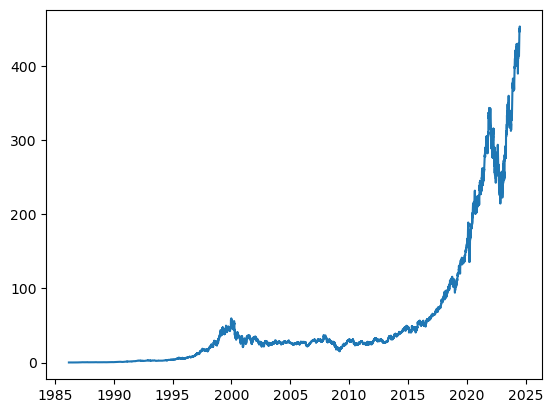

In [4]:
data.loc[:, 'Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [5]:
from copy import deepcopy as dc
import pandas as pd

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index(pd.to_datetime(df['Date']), inplace=True)
    df.drop(columns=['Date'], inplace=True)

    for i in range(1, n_steps + 1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)
    df = df.infer_objects()

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1986-03-24,0.090278,0.092882,0.095486,0.098090,0.099826,0.102431,0.100694,0.097222
1986-03-25,0.092014,0.090278,0.092882,0.095486,0.098090,0.099826,0.102431,0.100694
1986-03-26,0.094618,0.092014,0.090278,0.092882,0.095486,0.098090,0.099826,0.102431
1986-03-27,0.096354,0.094618,0.092014,0.090278,0.092882,0.095486,0.098090,0.099826
1986-03-31,0.095486,0.096354,0.094618,0.092014,0.090278,0.092882,0.095486,0.098090
...,...,...,...,...,...,...,...,...
2024-06-24,447.670013,449.779999,445.700012,446.339996,448.369995,442.570007,441.579987,441.059998
2024-06-25,450.950012,447.670013,449.779999,445.700012,446.339996,448.369995,442.570007,441.579987
2024-06-26,452.160004,450.950012,447.670013,449.779999,445.700012,446.339996,448.369995,442.570007


In [6]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[9.02780000e-02, 9.28820000e-02, 9.54860000e-02, ...,
        1.02431000e-01, 1.00694000e-01, 9.72220000e-02],
       [9.20140000e-02, 9.02780000e-02, 9.28820000e-02, ...,
        9.98260000e-02, 1.02431000e-01, 1.00694000e-01],
       [9.46180000e-02, 9.20140000e-02, 9.02780000e-02, ...,
        9.80900000e-02, 9.98260000e-02, 1.02431000e-01],
       ...,
       [4.52160004e+02, 4.50950012e+02, 4.47670013e+02, ...,
        4.46339996e+02, 4.48369995e+02, 4.42570007e+02],
       [4.52850006e+02, 4.52160004e+02, 4.50950012e+02, ...,
        4.45700012e+02, 4.46339996e+02, 4.48369995e+02],
       [4.46950012e+02, 4.52850006e+02, 4.52160004e+02, ...,
        4.49779999e+02, 4.45700012e+02, 4.46339996e+02]])

In [7]:
shifted_df_as_np.shape

(9644, 8)

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-1.        , -0.9999885 , -0.99997696, ..., -0.99994595,
        -0.99995353, -0.99996902],
       [-0.99999233, -1.        , -0.99998848, ..., -0.99995754,
        -0.99994578, -0.99995353],
       [-0.99998083, -0.99999233, -1.        , ..., -0.99996526,
        -0.9999574 , -0.99994578],
       ...,
       [ 0.99695202,  0.99160705,  0.98013585, ...,  0.98470055,
         1.        ,  0.97412335],
       [ 1.        ,  0.99695202,  0.99464688, ...,  0.98185421,
         0.99094316,  1.        ],
       [ 0.97393764,  1.        ,  1.        , ...,  1.        ,
         0.98808787,  0.99094316]])

In [9]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((9644, 7), (9644,))

In [10]:
X = dc(np.flip(X, axis=1))
X

array([[-0.99996902, -0.99995353, -0.99994595, ..., -0.99996535,
        -0.99997696, -0.9999885 ],
       [-0.99995353, -0.99994578, -0.99995754, ..., -0.9999769 ,
        -0.99998848, -1.        ],
       [-0.99994578, -0.9999574 , -0.99996526, ..., -0.99998845,
        -1.        , -0.99999233],
       ...,
       [ 0.97412335,  1.        ,  0.98470055, ...,  0.99480986,
         0.98013585,  0.99160705],
       [ 1.        ,  0.99094316,  0.98185421, ...,  0.98545002,
         0.99464688,  0.99695202],
       [ 0.99094316,  0.98808787,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

In [11]:
split_index = int(len(X) * 0.95)

split_index

9161

In [12]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9161, 7), (483, 7), (9161,), (483,))

In [13]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9161, 7, 1), (483, 7, 1), (9161, 1), (483, 1))

In [14]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([9161, 7, 1]),
 torch.Size([483, 7, 1]),
 torch.Size([9161, 1]),
 torch.Size([483, 1]))

In [15]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [16]:
train_dataset

In [17]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [19]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [20]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [21]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [22]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.336
Batch 200, Loss: 0.095
Batch 300, Loss: 0.021
Batch 400, Loss: 0.019
Batch 500, Loss: 0.012

Val Loss: 0.312
***************************************************

Epoch: 2
Batch 100, Loss: 0.004
Batch 200, Loss: 0.003
Batch 300, Loss: 0.002
Batch 400, Loss: 0.001
Batch 500, Loss: 0.001

Val Loss: 0.082
***************************************************

Epoch: 3
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000

Val Loss: 0.049
***************************************************

Epoch: 4
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000

Val Loss: 0.047
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000

Val Loss: 0.036
***************************************************

Epoch: 6
Batch 100, Loss: 0.00

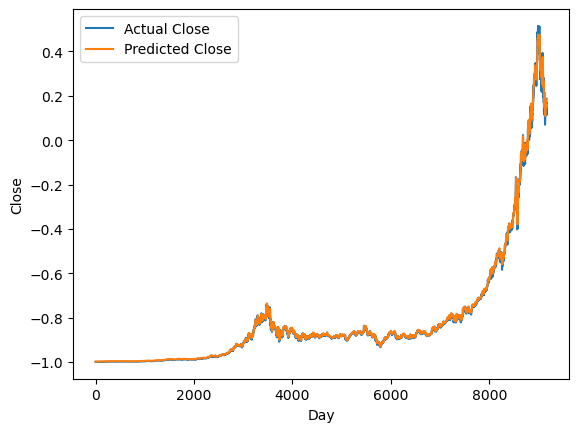

In [23]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [24]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  0.54520432,   0.54340971,   0.54247867, ..., 263.5376437 ,
       263.39898664, 261.27734199])

In [25]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([9.02780000e-02, 9.20186346e-02, 9.46228398e-02, ...,
       2.58829986e+02, 2.51899994e+02, 2.68739989e+02])

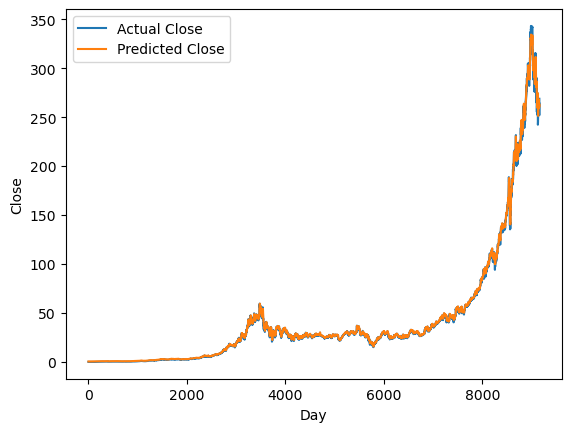

In [26]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [27]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([264.31771787, 268.46786299, 272.67550302, 275.15813371,
       276.44153462, 279.43612776, 282.23223459, 283.52397436,
       283.57721889, 283.95287212, 286.04813739, 287.259754  ,
       289.09540834, 290.88812704, 292.15135548, 292.89244752,
       293.0859818 , 291.98677781, 289.10528543, 286.25161623,
       283.75487156, 282.59421912, 279.02489272, 275.54215278,
       272.41532538, 269.90385954, 267.71153702, 264.86905375,
       261.8284215 , 261.26506309, 261.07726346, 262.66194259,
       264.55273052, 262.06871003, 260.37256283, 257.22951649,
       254.40353552, 252.1331813 , 249.59167939, 246.62802636,
       245.54539213, 243.85137686, 242.69049503, 241.54120394,
       242.06575564, 241.49608237, 239.83296   , 240.84353331,
       244.08294873, 246.60605928, 247.84464898, 244.99336808,
       241.48636046, 237.8180068 , 234.82315053, 234.82952611,
       233.14582647, 234.72453481, 236.65848104, 237.67469455,
       238.46809333, 240.79645521, 243.73246723, 247.08

In [28]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([276.41000417, 280.73999126, 278.01001168, 274.82000532,
       282.46999988, 283.64999495, 282.91000262, 280.32000582,
       282.29998778, 289.16000073, 287.0199917 , 291.91000098,
       293.47000087, 292.70999124, 291.32000681, 290.17001407,
       286.1499915 , 277.74999933, 276.44000313, 275.79000767,
       278.85000617, 268.08999686, 265.23000942, 262.97000118,
       261.47000257, 260.39999469, 256.05999895, 253.25000079,
       258.08999718, 258.51998789, 264.45999113, 266.6499928 ,
       251.99000567, 252.22000051, 245.38000486, 244.74000455,
       244.52000318, 242.44999735, 238.94999696, 240.97999602,
       237.91999837, 237.44999667, 236.41000377, 241.0700064 ,
       237.50000028, 232.89999388, 240.74000434, 248.88000441,
       249.19999781, 246.78999309, 234.24000506, 229.24999995,
       225.41000403, 225.74999998, 234.24000506, 228.55999794,
       237.52999924, 238.49999991, 236.479996  , 236.14999395,
       242.1199953 , 247.24999963, 250.66000399, 231.32

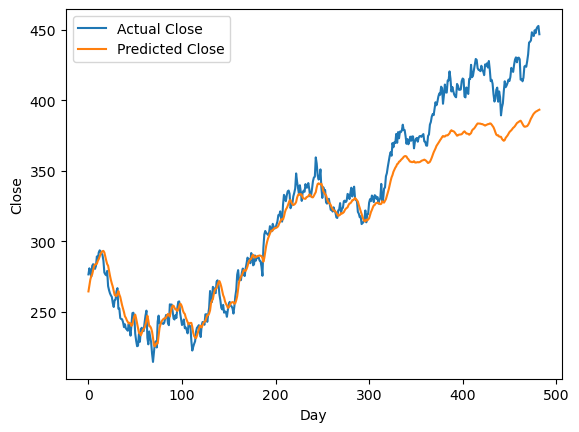

In [29]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()